In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights

import pandas as pd
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import itertools
from tqdm import tqdm
import pickle
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class MIDmodel2(nn.Module):
    def __init__(self):
        super(MIDmodel2, self).__init__()
        self.pretrained = resnet18(weights = ResNet18_Weights.DEFAULT)
        self.pretrained.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 4)

    def get_embeddings(self, x):
        x = self.pretrained(x)
        return x

    def forward(self, x):
        x = self.pretrained(x)
        x = self.fc1(x)
        return x
    
class ImageDataset(Dataset):
    def __init__(self, root_dir, patients_ids, patients_df, transform=None):
        self.patients_df = patients_df[patients_df["patient_id"].isin(patients_ids)]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.patients_df)

    def __getitem__(self, idx):
        row = self.patients_df.iloc[idx]
        path = os.path.join(self.root_dir, row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")
        image = Image.open(path)
        label = row["score"]

        if self.transform:
            image = self.transform(image)
            
        image = transforms.ToTensor()(image)
        image = transforms.Resize((224, 224))(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, int(label), path

In [4]:
data_dir = "images/"
images_paths = glob.glob(f"{data_dir}*.png", recursive=True)
images_df = pd.DataFrame([path[len(data_dir):-4].split("_") for path in images_paths], columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
images_df["score"] = images_df["score"].astype(str)
images_df["frame_number"] = images_df["frame_number"].astype(str)
images_df["spot"] = images_df["spot"].astype(str)
images_df["patient_id"] = images_df["patient_id"].astype(str)
images_df["exam_id"] = images_df["exam_id"].astype(str)
patients_ids = set(images_df["patient_id"])
patients_ids = list(patients_ids)

# select the 8 patients for training based on the most balanced distribution of the scores
combs = list(itertools.combinations(patients_ids, 8))
stds = []
for i, c in enumerate(combs):
    stds.append((images_df[images_df["patient_id"].isin(c)].groupby("score").count()["patient_id"].std(), i))
# sort the stds
train_patients = [x for x in combs[min(stds)[1]]]
print(train_patients)
print(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"])
test_patients = [x for x in patients_ids if x not in train_patients]
print(test_patients)
print(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"])

['1048', '1069', '1017', '1051', '1052', '1067', '1047', '1050']
score
0    7888
1    7540
2    7189
3    7592
Name: patient_id, dtype: int64
['1045', '1066', '1068']
score
0    6625
1    1721
2    5535
3    3631
Name: patient_id, dtype: int64


In [5]:
for patient in test_patients:
    # print the number of images for each score based on image_df
    print("Number of images for each score for patient", patient)
    result = images_df[images_df["patient_id"] == patient]["score"].value_counts()
    # sort the result by score
    result = result.sort_index()
    print(result)

max_number = 29
selected_df_test = pd.DataFrame()
for patient in test_patients:
    for score in range(0,4):
        # get the images for the patient and score
        patient_score_df = images_df[(images_df["patient_id"] == patient) & (images_df["score"] == f"{score}")]
        # if the number of images is less than 40, select all of them
        if len(patient_score_df) < max_number:
            selected_df_test = pd.concat([selected_df_test, patient_score_df])
        else:
            # select 29 images randomly
            selected_df_test = pd.concat([selected_df_test, patient_score_df.sample(n=max_number, random_state=42)])
print(len(selected_df_test))
# print the number of images for each score based on selected_df
print("Number of images for each score for the selected images")
result = selected_df_test["score"].value_counts()
# sort the result by score
result = result.sort_index()
print(result)

# create a new dataframe using each entry of the selected_df as path
paths_test_df = pd.DataFrame()
for index, row in selected_df_test.iterrows():
    # get the path
    path = os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png" )
    # create a new dataframe with the path
    tmp_df = pd.DataFrame({"path": [path]})
    # add the new dataframe to the values dataframe
    paths_test_df = pd.concat([paths_test_df, tmp_df])

Number of images for each score for patient 1045
0    6198
1      29
2     370
3     402
Name: score, dtype: int64
Number of images for each score for patient 1066
0     210
1     911
2    1707
3     677
Name: score, dtype: int64
Number of images for each score for patient 1068
0     217
1     781
2    3458
3    2552
Name: score, dtype: int64
348
Number of images for each score for the selected images
0    87
1    87
2    87
3    87
Name: score, dtype: int64


In [6]:
def getPath(row):
    return os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")

In [7]:
test_images_tmp = images_df[images_df["patient_id"].isin(test_patients)]
test_images_df = test_images_tmp.reset_index(drop=True)
test_images_df["path"] = test_images_df.apply(getPath, axis=1)
test_images_df = test_images_df[test_images_df["path"].isin(paths_test_df["path"])]
test_dataset = ImageDataset(data_dir, test_patients, test_images_df)

values_train = pd.read_csv("data/values_train.csv")
values_test = pd.read_csv("data/values_test.csv")
values_test = values_test[values_test["path"].isin(paths_test_df["path"])]
values_test = values_test.drop(values_test[values_test["correct"] == 1].sample(n=48, random_state=42).index)


100%|██████████| 348/348 [00:12<00:00, 26.80it/s]


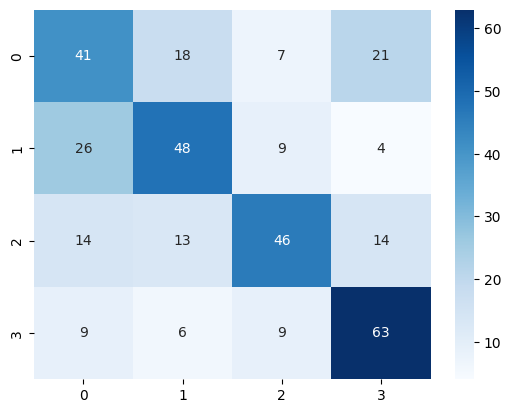

accuracy: 0.5689655172413793
precision: 0.571448955168922


In [8]:
# confusion matrix of the models/MIDmodel2.pt
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.eval()
model.to(device)
test_dataset = ImageDataset(data_dir, test_patients, test_images_df)
y_true = []
y_pred = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    y_true.append(label)
    y_pred.append(predicted.cpu().detach().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

print("accuracy:", accuracy_score(y_true, y_pred))
print("precision:", precision_score(y_true, y_pred, average="macro"))

Accuracy: 0.5433333333333333
Precision: 0.5437710437710438


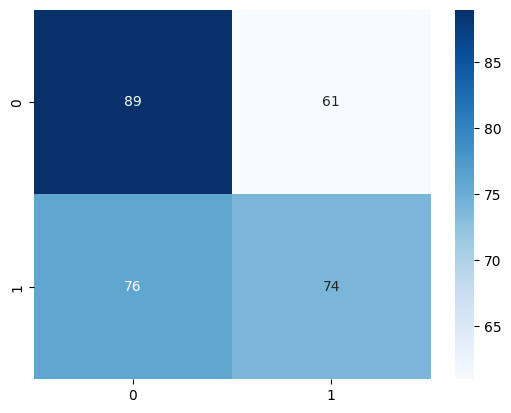

In [10]:
# confusion matrix of the binary model
with open("models/svc.pkl", "rb") as f:
    svc = pickle.load(f)

X_test = values_test.drop(["path", "correct", "predicted", "true"], axis=1)
y_true = values_test["correct"]
y_pred = svc.predict(X_test)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

100%|██████████| 300/300 [2:01:21<00:00, 24.27s/it]


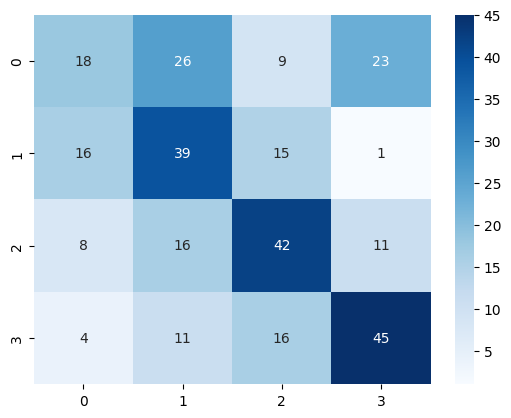

In [11]:
# confusion matrix of t-SNE
values_tsne = values_train.copy()
values_tsne.drop(columns=["path", "true", "predicted", "correct"], inplace=True)
y_true = []
y_pred = []
for i in tqdm(range(len(values_test))):
    element = values_test.iloc[i]
    sm0 = element["sm0"]
    sm1 = element["sm1"]
    sm2 = element["sm2"]
    sm3 = element["sm3"]
    values_tsne = pd.concat([values_tsne, pd.DataFrame([[sm0, sm1, sm2, sm3]], columns=["sm0", "sm1", "sm2", "sm3"])])
    points = values_tsne[["sm0", "sm1", "sm2", "sm3"]].values
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
    tsne_results = tsne.fit_transform(points)
    distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
    points_num = 12
    nearest_points = np.argsort(distances)[:points_num]
    nearest_points = np.delete(nearest_points, 0)
    scores = []
    for k in range(len(nearest_points)):
        scores.append(values_train.iloc[nearest_points[k]]["true"])
    mode_val = np.median(scores)
    values_tsne = values_tsne[:-1]
    y_true.append(element["true"])
    y_pred.append(mode_val)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [12]:
print("accuracy:", accuracy_score(y_true, y_pred))	
print("precision:", precision_score(y_true, y_pred, average="macro"))

accuracy: 0.48
precision: 0.47247812831389185


# FINAL MODEL

In [46]:
class MIDfinal2(nn.Module):
    def __init__(self, values_train: pd.DataFrame):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.to(device)
        self.MIDmodel.eval()
        self.binary_classifier = pickle.load(open("models/svc.pkl", "rb"))
        self.values_train = values_train

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        predicted_label = predicted_label.cpu().detach().numpy()
        predicted_label = pd.DataFrame(predicted_label, columns=["sm0", "sm1", "sm2", "sm3"])
        label_value = torch.argmax(res)

        results = []
        results.append(label_value)

        binary_output = self.binary_classifier.predict(predicted_label)
        binary_output = binary_output[0]
        results.append(binary_output)

        if binary_output == 0:
            values_tsne = self.values_train.copy()
            values_tsne.drop(columns=["path", "true", "predicted", "correct"], inplace=True)
            res = predicted_label
            res = pd.DataFrame(res, columns=["sm0", "sm1", "sm2", "sm3"])
            values_tsne = pd.concat([values_tsne, res])
            points = values_tsne[["sm0", "sm1", "sm2", "sm3"]].values
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
            tsne_results = tsne.fit_transform(points)
            distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
            points_num = 12
            nearest_points = np.argsort(distances)[:points_num]
            nearest_points = np.delete(nearest_points, 0)
            scores = []
            for k in range(len(nearest_points)):
                scores.append(self.values_train.iloc[nearest_points[k]]["true"])
            mode_val = max(set(scores), key=scores.count)
            results.append(mode_val)
            return results
        # trasform res to the final label
        res = torch.argmax(res).cpu().detach().numpy()
        results.append(res)
        return results

100%|██████████| 348/348 [1:15:31<00:00, 13.02s/it]


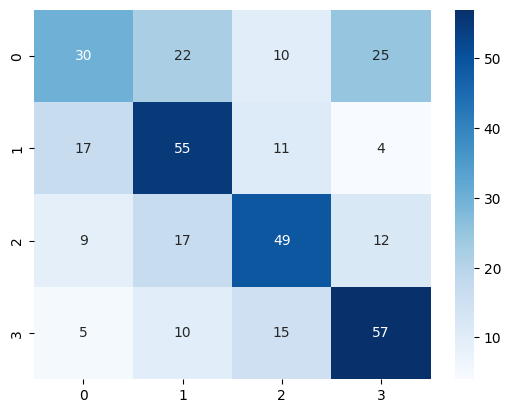

accuracy: 0.5488505747126436
precision: 0.5446881684577992


In [49]:
model = MIDfinal2(values_train)
model.eval()
y_true = []
y_pred = []
test_dataset = ImageDataset(data_dir, test_patients, test_images_df)
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    binary = output[0]
    resnet = output[1]
    output = output[2]
    y_true.append(label)
    y_pred.append(output)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

print("accuracy:", accuracy_score(y_true, y_pred))
print("precision:", precision_score(y_true, y_pred, average="macro"))